# Sentiment Analysis with Transfer Learning and Fine-tuning

This notebook demonstrates how to fine-tune a pre-trained model for a binary sentiment analysis task.

## 1. Setup and Imports

In [1]:
%pip install torch transformers pandas scikit-learn datasets psutil 
%pip install --upgrade ipywidgets
%pip install ydata-profiling
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import psutil
from collections import defaultdict
from datasets import load_dataset, Dataset, DatasetDict
from datasets import Features, Value
from typing import Dict, List
import warnings
from tqdm import tqdm

# from rich import print
# from rich.console import Console
# from rich.progress import track

from ydata_profiling import ProfileReport
import webbrowser

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, SubsetRandomSampler
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from transformers import (
    DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification,
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel
)
from transformers import logging, get_linear_schedule_with_warmup, AdamW, AutoTokenizer

logging.set_verbosity_error()
warnings.filterwarnings('ignore')

## 2. System Information

In [3]:
# System information
print("=== System Info ===")
print(f"PyTorch version: {torch.__version__}")
print(f"CPU cores: {psutil.cpu_count()}")
print(f"RAM: {psutil.virtual_memory().total / (1024 ** 3):.2f} GB")
print("\n=== GPU Info ===")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

=== System Info ===
PyTorch version: 2.4.1+cpu
CPU cores: 28
RAM: 15.70 GB

=== GPU Info ===
CUDA available: False


In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 3. Load and Analyze Datasets

#### Getting the datasets reviews from Hugging Face:
https://huggingface.co/datasets/stanfordnlp/imdb

In [5]:
# Load datasets
df_sample = pd.read_parquet('../data/sample_reviews.parquet')
print("'SAMPLE REVIEWS' columns:", df_sample.columns.tolist())

imdb = load_dataset("stanfordnlp/imdb")
df_imdb = pd.DataFrame(imdb['train'])
print("\n'IMDB' columns:", df_imdb.columns.tolist())

'SAMPLE REVIEWS' columns: ['sentence', 'label', 'idx']

'IMDB' columns: ['text', 'label']


In [6]:
# Save datasets to csv
sample_output_path = '../data/sample_reviews.csv'
df_sample.to_csv(sample_output_path, index=False)
print(f"SAMPLE REVIEWS dataset saved as CSV: {sample_output_path}")

imdb_output_path = '../data/imdb_reviews.csv'
df_imdb.to_csv(imdb_output_path, index=False)
print(f"IMDB dataset saved as CSV:           {imdb_output_path}")

print(f"SAMPLE REVIEWS -> ROWS: {len(df_sample):,},\tCOLUMNS: {len(df_sample.columns)}")
print(f"IMDB ->           ROWS: {len(df_imdb):,},\tCOLUMNS: {len(df_imdb.columns)}")

SAMPLE REVIEWS dataset saved as CSV: ../data/sample_reviews.csv
IMDB dataset saved as CSV:           ../data/imdb_reviews.csv
SAMPLE REVIEWS -> ROWS: 150,	COLUMNS: 3
IMDB ->           ROWS: 25,000,	COLUMNS: 2



=== 'SAMPLE REVIEWS' INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  150 non-null    object
 1   label     150 non-null    int64 
 2   idx       150 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.1+ KB
None

=== 'SAMPLE REVIEWS' DESCRIBE ===
            label         idx
count  150.000000  150.000000
mean     0.506667  439.466667
std      0.501630  256.759299
min      0.000000    3.000000
25%      0.000000  219.000000
50%      1.000000  422.000000
75%      1.000000  666.750000
max      1.000000  869.000000

=== 'SAMPLE REVIEWS' HEAD ===
                                            sentence  label  idx
0  at least one scene is so disgusting that viewe...      0  413
1  even the finest chef ca n't make a hotdog into...      0  701
2  collateral damage finally delivers the goods f...      1  834
3  exciting an

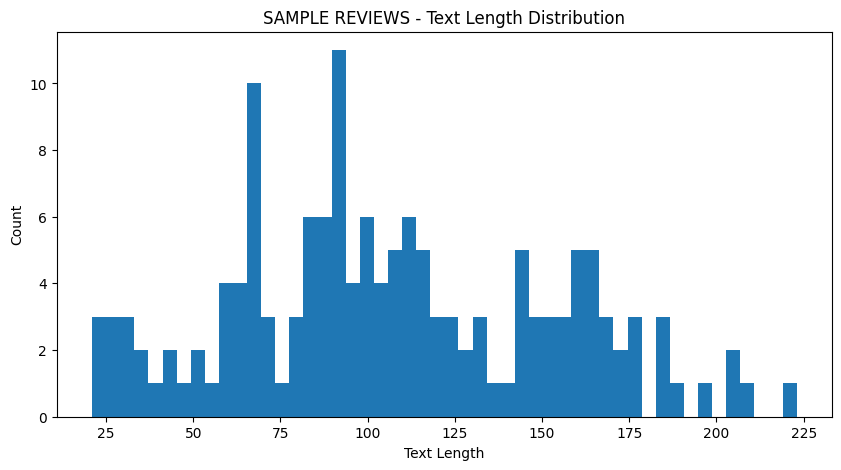


=== 'IMDB' INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None

=== 'IMDB' DESCRIBE ===
             label
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000

=== 'IMDB' HEAD ===
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0

=== 'IMDB' ANALYSIS ===
Total samples: 25000
Label distribution:
label
0    0.5
1    0.5
Nam

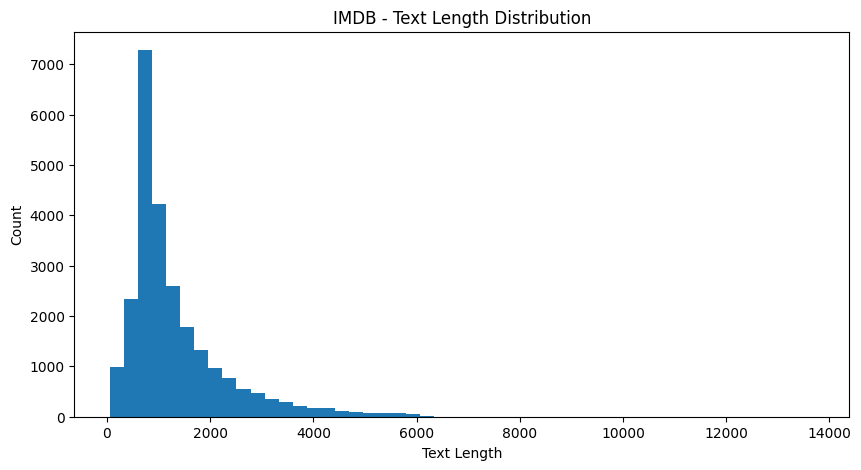

In [7]:
# Analyze datasets
datasets = {
    'SAMPLE REVIEWS': (df_sample, 'sentence'),
    'IMDB': (df_imdb, 'text')
}

for name, (df, text_col) in datasets.items():
    print(f"\n=== '{name}' INFO ===")
    print(df.info())
    
    print(f"\n=== '{name}' DESCRIBE ===")
    print(df.describe())
    
    print(f"\n=== '{name}' HEAD ===")
    print(df.head())
        
    print(f"\n=== '{name}' ANALYSIS ===")
    print(f"Total samples: {len(df)}")
    print(f"Label distribution:\n{df['label'].value_counts(normalize=True)}")
    
    # Text length statistics
    print(f"\n=== '{name}' STATS ===")
    lengths = df[text_col].str.len()
    word_lengths = df[text_col].str.split().str.len()
    print(f"\nText length statistics:")
    print(f"Mean   Chars: {lengths.mean():.2f}")
    print(f"Median Chars: {lengths.median():.2f}")
    print(f"Max    Chars: {lengths.max()}")
    print(f"Avg    Words: {word_lengths.mean():.2f}")
    print(f"Max    Words: {word_lengths.max()}")
    print(f"Min    Words: {word_lengths.min()}")
    print(f"Memory Usage (MB): {round(df.memory_usage(deep=True).sum() / 1024**2, 4)}")
        
    # Visualize length distribution
    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=50)
    plt.title(f'{name} - Text Length Distribution')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.show()

In [8]:
# Generate report from datasets
datasets = {
    'SAMPLE REVIEWS': df_sample,
    'IMDB': df_imdb,
}
for name, df in datasets.items():
    if isinstance(df, pd.DataFrame):  
        profile = ProfileReport(df, title=f"Dataset {name.upper()}")
        profile.to_notebook_iframe()
        report_path = f"../reports/ydata_report_{name.upper()}.html"
        profile.to_file(report_path)
        webbrowser.open('file://' + os.path.realpath(report_path))
    else:
        print(f"Warning: {name} is not a pandas DataFrame")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Dataset Preparation

#### Select dataset

In [9]:
data = df_sample
# data = pd.DataFrame(df_imdb)

print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  150 non-null    object
 1   label     150 non-null    int64 
 2   idx       150 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.1+ KB
None
                                            sentence  label  idx
0  at least one scene is so disgusting that viewe...      0  413
1  even the finest chef ca n't make a hotdog into...      0  701
2  collateral damage finally delivers the goods f...      1  834
3  exciting and direct , with ghost imagery that ...      1  821
4  and when you 're talking about a slapstick com...      0  748


In [10]:
# Set parameters
MAX_SAMPLES = 500  
TEST_SIZE = 0.20
VAL_SIZE = 0.10

In [11]:
# Prepare data
# Sample data if MAX_SAMPLES is set and less than dataset size
if MAX_SAMPLES and MAX_SAMPLES < len(data):
    data = data.sample(n=MAX_SAMPLES, random_state=42)
    print(f"Sampled {MAX_SAMPLES} examples from dataset")

text_column = 'sentence' if 'sentence' in data.columns else 'text'
texts = data[text_column].values
labels = data['label'].values

print(f"Final dataset size: {len(texts)}")
print(f"Label distribution:\n{pd.Series(labels).value_counts(normalize=True)}")

Final dataset size: 150
Label distribution:
1    0.506667
0    0.493333
Name: proportion, dtype: float64


In [12]:
# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, 
	test_size=TEST_SIZE, 
	random_state=42, 
	stratify=labels
)

# Split train set into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, 
    test_size=VAL_SIZE/(1-TEST_SIZE), 
    random_state=42,
    stratify=train_labels
)

In [13]:
# Print split sizes and distributions
split_sizes = {
    "Dataset": ["TRAIN", "VAL", "TEST"],
    "Samples": [len(train_texts), len(val_texts), len(test_texts)],
    "      %": [
        len(train_texts) / len(texts) * 100,
        len(val_texts) / len(texts) * 100,
        len(test_texts) / len(texts) * 100
    ]
}

# Print label distribution for each split
label_distributions = {
    "Dataset": ["TRAIN", "VAL  ", "TEST "],
    "Distribution": [
        {k: f"{v:.2f}" for k, v in pd.Series(train_labels).value_counts(normalize=True).to_dict().items()},
        {k: f"{v:.2f}" for k, v in pd.Series(val_labels).value_counts(normalize=True).to_dict().items()},
        {k: f"{v:.2f}" for k, v in pd.Series(test_labels).value_counts(normalize=True).to_dict().items()}
    ]
}

# Print stats from text lengths
train_lengths = [len(text.split()) for text in train_texts]
val_lengths = [len(text.split()) for text in val_texts]
test_lengths = [len(text.split()) for text in test_texts]

length_stats = {
    "Dataset": ["TRAIN", "VAL", "TEST"],
    "   AVG": [
        np.mean(train_lengths),
        np.mean(val_lengths),
        np.mean(test_lengths)
    ],
    "   MAX": [
        np.max(train_lengths),
        np.max(val_lengths),
        np.max(test_lengths)
    ],
    "   MIN": [
        np.min(train_lengths),
        np.min(val_lengths),
        np.min(test_lengths)
    ]
}

split_sizes_df = pd.DataFrame(split_sizes)
length_stats_df = pd.DataFrame(length_stats)
label_distributions_df = pd.DataFrame(label_distributions)

print("\nDataset splits:")
print(split_sizes_df.to_string(index=False, float_format="{:.1f}".format))

print("\nLabel distribution in splits:")
for idx, row in label_distributions_df.iterrows():
    print(f"{row['Dataset']} set: {row['Distribution']}")

print("\nText length statistics:")
print(length_stats_df.to_string(index=False, float_format="{:.1f}".format))

# Show examples from each dataset
print("\nSample texts from each dataset:")
print("\nTRAIN examples:")
for i in range(3):
    text = train_texts[i]
    print(f"{i+1}. Chars: {len(text)}, Words: {len(text.split())}")
    print(f"Text: {text[:70]}...")

print("\nVAL examples:")
for i in range(3):
    text = val_texts[i]
    print(f"{i+1}. Chars: {len(text)}, Words: {len(text.split())}")
    print(f"Text: {text[:70]}...")

print("\nTEST examples:")
for i in range(3):
    text = test_texts[i]
    print(f"{i+1}. Chars: {len(text)}, Words: {len(text.split())}")
    print(f"Text: {text[:70]}...")


Dataset splits:
Dataset  Samples        %
  TRAIN      105     70.0
    VAL       15     10.0
   TEST       30     20.0

Label distribution in splits:
TRAIN set: {1: '0.50', 0: '0.50'}
VAL   set: {1: '0.53', 0: '0.47'}
TEST  set: {1: '0.50', 0: '0.50'}

Text length statistics:
Dataset     AVG     MAX     MIN
  TRAIN    19.2      38       5
    VAL    19.8      33       5
   TEST    21.7      43       9

Sample texts from each dataset:

TRAIN examples:
1. Chars: 67, Words: 12
Text: all that 's missing is the spontaneity , originality and delight . ...
2. Chars: 110, Words: 18
Text: if director michael dowse only superficially understands his character...
3. Chars: 72, Words: 13
Text: this is human comedy at its most amusing , interesting and confirming ...

VAL examples:
1. Chars: 157, Words: 27
Text: a compelling spanish film about the withering effects of jealousy in t...
2. Chars: 129, Words: 23
Text: it 's an offbeat treat that pokes fun at the democratic exercise while...
3. Chars

## 5. Model and Platform Research

#### Models:
- BERT
- RoBERTa
- DistilBERT
- GPT-2
- Electra
- XLNet

**DistilBERT** is good balance between performance and computational efficiency. It is a lighter and faster version of BERT.

#### Computing platforms:
- AWS Sagemaker Studio Labs
- Google Colab

In [14]:
class ModelComparator:
    def __init__(self):
        self.models: Dict = {}
        self.tokenizers: Dict = {}
        self.results: List = []

    def load_model(self, model_name: str, verbose: bool = True):
        """Loads a model and its tokenizer."""
        if verbose:
            print(f"Loading {model_name}...", end=' ')

        model_configs = {
            'distilbert': ('distilbert-base-uncased', DistilBertTokenizer, DistilBertModel),
            'bert': ('bert-base-uncased', BertTokenizer, BertModel),
            'roberta': ('roberta-base', RobertaTokenizer, RobertaModel),
        }

        if model_name in model_configs:
            model_path, TokenizerClass, ModelClass = model_configs[model_name]
            try:
                # Load model and tokenizer
                tokenizer = TokenizerClass.from_pretrained(model_path)
                model = ModelClass.from_pretrained(model_path)

                if model_name == 'gpt2':
                    tokenizer.pad_token = tokenizer.eos_token

                self.models[model_name] = model
                self.tokenizers[model_name] = tokenizer

                if verbose:
                    print("✓")

            except Exception as e:
                if verbose:
                    print(f"❌ Error: {str(e)}")
                raise
        else:
            raise ValueError(f"Unsupported model: {model_name}")

    def show_tokenization(self, text: str):
        """Display tokenization results for each model."""
        print("\n=== Tokenization Comparison ===")
        print(f"Original text: {text}\n")
        
        for model_name, tokenizer in self.tokenizers.items():
            print(f"\n{model_name.upper()} Tokenization:")
            # Tokenize the text
            tokens = tokenizer.tokenize(text)
            encoded = tokenizer.encode(text)
            
            # Display results
            print(f"Number of tokens: {len(tokens)}")
            print("Tokens:", tokens)
            print(f"Token IDs: {encoded}")
            print("Decoded back:", tokenizer.decode(encoded))
            
            # Display special tokens
            print("\nSpecial tokens:")
            for token_name, token in tokenizer.special_tokens_map.items():
                print(f"{token_name}: {token}")

    def measure_performance(self, model_name: str, text: str, num_runs: int = 5, verbose: bool = True):
        """Measures model performance for a given text."""
        if not self.models:
            print("No models loaded. Please load models first.")
            return

        if model_name not in self.models:
            print(f"Model {model_name} not found.")
            return

        model = self.models[model_name]
        tokenizer = self.tokenizers[model_name]

        if verbose:
            print(f"Testing {model_name}...", end=' ')

        # Performance measurements
        total_time = 0
        memory_usage = []

        # Prepare input
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

        if model_name == 'xlnet':
            inputs['token_type_ids'] = torch.zeros_like(inputs['input_ids'])

        # Multiple runs for averaging
        for _ in range(num_runs):
            start_time = time.time()
            with torch.no_grad():
                outputs = model(**inputs)
            end_time = time.time()

            total_time += (end_time - start_time)
            memory_usage.append(psutil.Process().memory_info().rss / 1024 / 1024)

        avg_time = total_time / num_runs
        avg_memory = np.mean(memory_usage)

        self.results.append({
            'model': model_name,
            'avg_time_ms': round(avg_time * 1000, 2),
            'avg_memory_mb': round(avg_memory, 2),
            'parameters': sum(p.numel() for p in model.parameters()),
            'input_length': len(inputs['input_ids'][0])
        })

        if verbose:
            print("✓")

    def display_results(self):
        """Shows results in a DataFrame."""
        if not self.results:
            print("No results available. Please run performance tests first.")
            return None

        df = pd.DataFrame(self.results)

        # Add relative speed comparison (normalized to BERT)
        if 'bert' in df['model'].values:
            bert_time = df[df['model'] == 'bert']['avg_time_ms'].values[0]
            df['relative_speed'] = bert_time / df['avg_time_ms']

        return df

def main():
    print("Starting model comparison...")

    # Sample texts for analysis (English and Spanish)
    texts = [
        """This is a longer text that allows us to see how different models behave
        with more extensive content. We want to analyze the differences in processing
        time and memory usage across various transformer architectures.""",
        
        """Este es un texto más largo que nos permite ver cómo se comportan los diferentes
        modelos con contenido más extenso. Queremos analizar las diferencias en el tiempo
        de procesamiento y uso de memoria entre varias arquitecturas de transformers."""
    ]

    comparator = ModelComparator()
    models = ['distilbert', 'bert', 'roberta']

    # Load models
    print("\nLoading models:")
    for model in models:
        try:
            comparator.load_model(model)
        except Exception as e:
            print(f"❌ Skipped {model}: {str(e)}")

    # Show tokenization for each text
    print("\nComparing tokenization for English text:")
    comparator.show_tokenization(texts[0])
    
    print("\nComparing tokenization for Spanish text:")
    comparator.show_tokenization(texts[1])

    # Run performance tests for both texts
    print("\nRunning performance tests:")
    for i, text in enumerate(texts):
        print(f"\nTesting {'English' if i == 0 else 'Spanish'} text ({len(text)} characters)")
        for model in comparator.models:
            comparator.measure_performance(model, text)

    # Show results
    results = comparator.display_results()
    if results is not None:
        print("\nComparison Results:")
        print(results.to_string(index=False))
        print()

    return results

if __name__ == "__main__":
    main()

Starting model comparison...

Loading models:
Loading distilbert... ✓
Loading bert... ✓
Loading roberta... ✓

Comparing tokenization for English text:

=== Tokenization Comparison ===
Original text: This is a longer text that allows us to see how different models behave
        with more extensive content. We want to analyze the differences in processing
        time and memory usage across various transformer architectures.


DISTILBERT Tokenization:
Number of tokens: 38
Tokens: ['this', 'is', 'a', 'longer', 'text', 'that', 'allows', 'us', 'to', 'see', 'how', 'different', 'models', 'behave', 'with', 'more', 'extensive', 'content', '.', 'we', 'want', 'to', 'analyze', 'the', 'differences', 'in', 'processing', 'time', 'and', 'memory', 'usage', 'across', 'various', 'transform', '##er', 'architecture', '##s', '.']
Token IDs: [101, 2023, 2003, 1037, 2936, 3793, 2008, 4473, 2149, 2000, 2156, 2129, 2367, 4275, 16582, 2007, 2062, 4866, 4180, 1012, 2057, 2215, 2000, 17908, 1996, 5966, 1999, 636

## 6. Hyperparameter optimization

In [15]:
# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # A pre-trained model from Hugging Face
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',  # "uncased" means it converts all text to lowercase
    num_labels=2,  # Specifies this is a binary classification task
	dropout=0.1,  # Dropout rate, used to prevent overfitting 
).to(device)

# Tokenize all texts
train_texts_encoded = tokenizer(train_texts.tolist(), truncation=True, padding=True)

train_dataset_hyperparams = TensorDataset(
    torch.tensor(train_texts_encoded['input_ids']),
    torch.tensor(train_texts_encoded['attention_mask']),
    torch.tensor(train_labels)
)

In [16]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, num_epochs):
    """
    Train the model and evaluate it on validation set
    Returns the best validation accuracy
    """
    best_val_accuracy = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                predictions = torch.argmax(outputs.logits, dim=-1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)
        
        val_accuracy = (correct / total) * 100
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            
    return best_val_accuracy

def grid_search_with_cross_validation(train_dataset, device, n_splits=5):
    """
    Perform grid search with k-fold cross validation
    """
    # Define parameter grid
    param_grid = {
        'learning_rate': [3e-5, 5e-5],
        'batch_size': [16, 32],
        'dropout': [0.1, 0.15],
        'weight_decay': [0.005, 0.01],
        'num_epochs': [3, 4]
    }

    # Initialize K-Fold
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Track results
    best_mean_accuracy = 0
    best_params = None
    all_results = []

    # Get total number of combinations
    total_combinations = len(list(ParameterGrid(param_grid)))
    print(f"\nTotal combinations to try: {total_combinations}")

    # Try each combination
    for i, params in enumerate(ParameterGrid(param_grid), 1):
        print("\n" + "="*50)
        print(f"Trying combination {i}/{total_combinations}")
        print(f"Parameters: {params}")
        print("="*50)
        
        # Store accuracies for each fold
        fold_accuracies = []
        
        # Perform k-fold cross validation
        for fold, (train_idx, val_idx) in enumerate(kfold.split(range(len(train_dataset))), 1):
            print(f"\nFold {fold}/{n_splits}")
            
            # Create data loaders for this fold
            train_sampler = SubsetRandomSampler(train_idx)
            val_sampler = SubsetRandomSampler(val_idx)
            
            train_loader = DataLoader(
                train_dataset, 
                batch_size=params['batch_size'], 
                sampler=train_sampler
            )
            val_loader = DataLoader(
                train_dataset, 
                batch_size=params['batch_size'], 
                sampler=val_sampler
            )
            
            # Initialize model for this fold
            model = DistilBertForSequenceClassification.from_pretrained(
                'distilbert-base-uncased',
                num_labels=2,
                dropout=params['dropout']
            ).to(device)

            # Initialize optimizer
            optimizer = AdamW([
                {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'LayerNorm' not in n],
                 'weight_decay': params['weight_decay']},
                {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'LayerNorm' in n],
                 'weight_decay': 0.0}
            ], lr=params['learning_rate'])
            
            # Train and evaluate for this fold
            fold_accuracy = train_and_evaluate(
                model, 
                optimizer, 
                train_loader, 
                val_loader, 
                params['num_epochs']
            )
            fold_accuracies.append(fold_accuracy)
            print(f"Fold {fold} accuracy: {fold_accuracy:.2f}%")
        
        # Calculate mean and std of accuracies across folds
        mean_accuracy = np.mean(fold_accuracies)
        std_accuracy = np.std(fold_accuracies)
        
        print(f"\nCross-validation results for current parameters:")
        print(f"🎯 Mean accuracy: {mean_accuracy:.2f}% (±{std_accuracy:.2f})")
        
        # Track results
        all_results.append({
            'params': params,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'fold_accuracies': fold_accuracies
        })
        
        # Update best parameters if needed
        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_params = params
            print("\n💥 New best parameters found!")
            print(f"✅ Best mean accuracy: {best_mean_accuracy:.2f}%")
            print(f"Parameters: {best_params}")
        else:
            print(f"✅ Best mean accuracy: {best_mean_accuracy:.2f}%")
            print(f"Parameters: {best_params}")

    return best_params, all_results, best_mean_accuracy


In [17]:
# Ask if the user wants to run the grid search
run_grid_search = input("Do you want to run the grid search? (yes/no): ").strip().lower()

if run_grid_search == "yes":
    # Measure execution time with %%time
    print("Starting the grid search...")
    from time import time  # Import time for measuring execution duration
    start_time = time()
    
    best_params, results, best_mean_accuracy = grid_search_with_cross_validation(
        train_dataset=train_dataset_hyperparams,
        device=device,
        n_splits=5  # Number of folds
    )
    elapsed_time = time() - start_time
    print(f"\nGrid Search completed in {elapsed_time:.2f} seconds!")
    
    # Print results
    print(f"\nBest parameters found (mean accuracy: {best_mean_accuracy:.2f}%):")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # Detailed results output
    print("\nDetailed results for all parameter combinations:")
    for result in sorted(results, key=lambda x: x['mean_accuracy'], reverse=True):
        print(f"\nParameters: {result['params']}")
        print(f"Mean accuracy: {result['mean_accuracy']:.2f}% (±{result['std_accuracy']:.2f})")

else:
    # Hardcoded values for `best_params`
    print("Using hardcoded best parameters...")
    best_params = { # Best parameters found from grid search from previous run (SAMPLE REVIEWS dataset 30')
        'learning_rate': 3e-5, # Learning rate for the optimizer
        'batch_size': 16,      # Number of samples per batch, used for gradient updates
        'dropout': 0.1,        # Dropout rate for regularization, to prevent overfitting
        'weight_decay': 0.005, # Weight decay for regularization, to prevent overfitting
        'num_epochs': 4        # Number of epochs to train the model, one epoch is one pass through the dataset
    }
    print(f"Hardcoded best parameters: {best_params}")

Using hardcoded best parameters...
Hardcoded best parameters: {'learning_rate': 3e-05, 'batch_size': 16, 'dropout': 0.1, 'weight_decay': 0.005, 'num_epochs': 4}


## 6. Model and Tokenizer Initialization

In [18]:
# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')  # A pre-trained model from Hugging Face
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',  # "uncased" means it converts all text to lowercase
    num_labels=2,  # Specifies this is a binary classification task
	dropout=best_params['dropout'],  # Dropout rate, used to prevent overfitting 
).to(device)

In [19]:
# Visualize tokenization example
print("\n=== Tokenization Example ===")
sample_text = train_texts[0]
print(f"Original text: {sample_text}")
tokenized = tokenizer(sample_text, truncation=True, padding=True, return_tensors='pt')
print(f"Words in text:    {len(sample_text.split())}")
print(f"Tokenized length: {len(tokenized['input_ids'][0])}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])[:]}")


=== Tokenization Example ===
Original text: all that 's missing is the spontaneity , originality and delight . 
Words in text:    12
Tokenized length: 19
Tokens: ['[CLS]', 'all', 'that', "'", 's', 'missing', 'is', 'the', 'sp', '##ont', '##ane', '##ity', ',', 'original', '##ity', 'and', 'delight', '.', '[SEP]']


## 7. Dataset Creation

In [20]:
# Tokenize all texts
train_texts_encoded = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_texts_encoded = tokenizer(val_texts.tolist(), truncation=True, padding=True)
test_texts_encoded = tokenizer(test_texts.tolist(), truncation=True, padding=True)

In [21]:
# Create TensorDatasets
train_dataset = TensorDataset(
    torch.tensor(train_texts_encoded['input_ids']),
    torch.tensor(train_texts_encoded['attention_mask']),
    torch.tensor(train_labels)
)

val_dataset = TensorDataset(
    torch.tensor(val_texts_encoded['input_ids']),
    torch.tensor(val_texts_encoded['attention_mask']),
    torch.tensor(val_labels)
)

test_dataset = TensorDataset(
    torch.tensor(test_texts_encoded['input_ids']),
    torch.tensor(test_texts_encoded['attention_mask']),
    torch.tensor(test_labels)
)

In [22]:
print("Datasets created successfully!")
print(f"Train dataset size:      {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size:       {len(test_dataset)}")

Datasets created successfully!
Train dataset size:      105
Validation dataset size: 15
Test dataset size:       30


In [23]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

In [24]:
# Show batch structure
sample_batch = next(iter(train_loader))
print("\n=== Batch Structure ===")
print(f"Input IDs shape:      {sample_batch[0].shape}")
print(f"Attention mask shape: {sample_batch[1].shape}")
print(f"Labels shape:         {sample_batch[2].shape}")


=== Batch Structure ===
Input IDs shape:      torch.Size([16, 54])
Attention mask shape: torch.Size([16, 54])
Labels shape:         torch.Size([16])


## 9. Training

In [25]:
def evaluate_model(model, dataloader, device):
    """Evaluate the model and return loss and accuracy."""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            total_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions) * 100
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, accuracy, predictions, true_labels

In [26]:
# Create optimizer
optimizer = optim.AdamW([
    {'params': [p for n, p in model.named_parameters() if 'bias' not in n and 'LayerNorm' not in n],
     'weight_decay': 0.005},  # Reducir weight decay
    {'params': [p for n, p in model.named_parameters() if 'bias' in n or 'LayerNorm' in n],
     'weight_decay': 0.0}
], lr=best_params['learning_rate'])

# Create learning rate scheduler
num_training_steps = len(train_loader) * best_params['num_epochs']
num_warmup_steps = num_training_steps // 20  # 5% of training steps
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

In [27]:
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0
patience = 4
patience_counter = 0

In [28]:
for epoch in range(best_params['num_epochs']):
    # Training
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{best_params['num_epochs']}")
    
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step() 
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Validation
    val_loss, val_acc, val_preds, val_true = evaluate_model(model, val_loader, device)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"New best model saved with accuracy: {val_acc:.2f}%")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    # Save metrics
    avg_train_loss = total_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\n🎯 Epoch {epoch+1} Summary:")
    print(f"📊 Average training loss: {avg_train_loss:.4f}")
    print(f"📈 Validation loss:       {val_loss:.4f}")
    print(f"✅ Validation accuracy:   {val_acc:.2f}%")
    print("\nValidation Classification Report:")
    print(classification_report(val_true, val_preds))
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"💥 New best model saved with accuracy: {val_acc:.2f}%")

Epoch 1/4: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s, loss=0.6831]


New best model saved with accuracy: 73.33%

🎯 Epoch 1 Summary:
📊 Average training loss: 0.6922
📈 Validation loss:       0.6745
✅ Validation accuracy:   73.33%

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       1.00      0.50      0.67         8

    accuracy                           0.73        15
   macro avg       0.82      0.75      0.72        15
weighted avg       0.83      0.73      0.72        15



Epoch 2/4: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s, loss=0.6089]


New best model saved with accuracy: 93.33%

🎯 Epoch 2 Summary:
📊 Average training loss: 0.6429
📈 Validation loss:       0.6326
✅ Validation accuracy:   93.33%

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15



Epoch 3/4: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s, loss=0.5523]



🎯 Epoch 3 Summary:
📊 Average training loss: 0.6004
📈 Validation loss:       0.5900
✅ Validation accuracy:   93.33%

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15



Epoch 4/4: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s, loss=0.5389]


🎯 Epoch 4 Summary:
📊 Average training loss: 0.5438
📈 Validation loss:       0.5624
✅ Validation accuracy:   93.33%

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.88      0.93         8

    accuracy                           0.93        15
   macro avg       0.94      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15



## 10. Final Evaluation


In [29]:
print("\n=== Final Evaluation ===")
test_loss, test_acc, test_preds, test_true = evaluate_model(model, test_loader, device)
print("\nTest Results:")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("\nTest Classification Report:")
print(classification_report(test_true, test_preds))


=== Final Evaluation ===

Test Results:
Test Loss:     0.6234
Test Accuracy: 80.00%

Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        15
           1       0.91      0.67      0.77        15

    accuracy                           0.80        30
   macro avg       0.82      0.80      0.80        30
weighted avg       0.82      0.80      0.80        30



## 11. Plot Training History


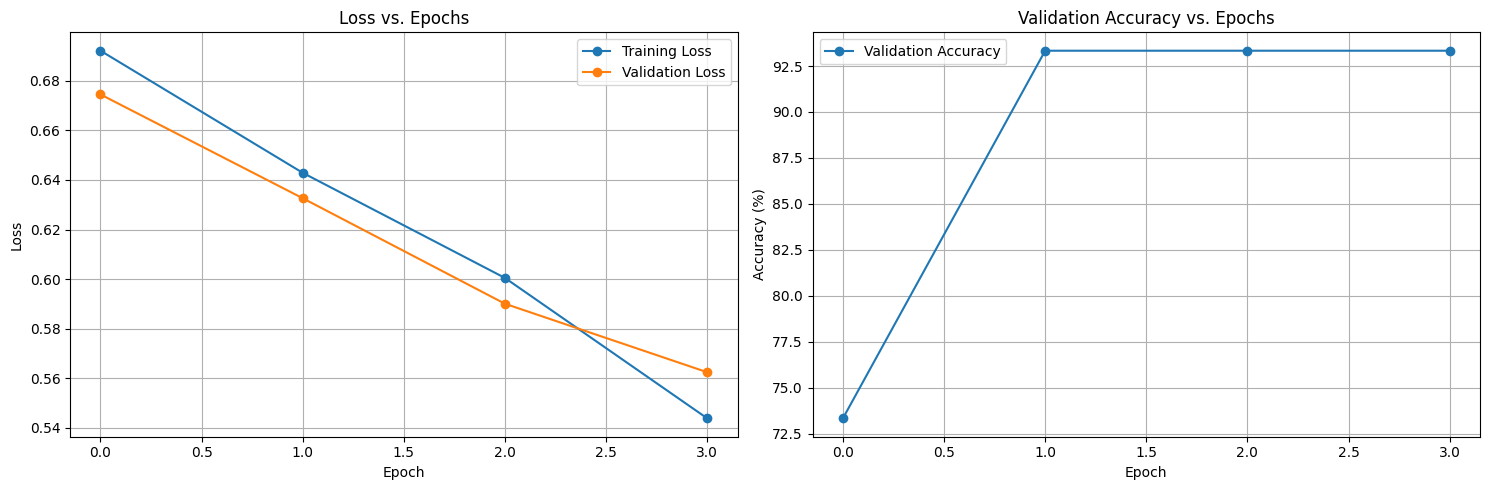

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 12. Save Model

In [31]:
model_save_path = '../models/sentiment_model'

model.config.problem_type = "single_label_classification"
model.config.model_type = "distilbert"
model.config.num_labels = 2  

model.save_pretrained(
    model_save_path,
    save_config=True,
    push_to_hub=False,
    safe_serialization=True  
)
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved in {model_save_path}")

Model and tokenizer saved in ../models/sentiment_model


In [32]:
time.sleep(1)

if os.path.exists('best_model.pt'):
    os.remove('best_model.pt')
    print("🗑️ Removed temporary checkpoint file (best_model.pt)")

🗑️ Removed temporary checkpoint file (best_model.pt)


In [33]:
# Print final summary
print("\n=== Training Complete ===")
print(f"✅ Best validation accuracy: {best_val_acc:.2f}%")
print(f"💫 Final test accuracy:      {test_acc:.2f}%")


=== Training Complete ===
✅ Best validation accuracy: 93.33%
💫 Final test accuracy:      80.00%
